In [1]:
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=24'

%load_ext autoreload
%autoreload 2

from brax import envs
from brax.io import html
from brax.training import normalization


import flax
import jax
import jax.numpy as jnp
from brax.envs import create_fn

from IPython.display import HTML, clear_output

import optax

import matplotlib.pyplot as plt
import numpy as np

from controllers import GruController, MlpController, LinearController
from common import do_local_apg, add_guassian_noise, add_uniform_noise, add_uniform_and_pareto_noise, add_sym_pareto_noise, do_one_rollout

from functools import partial

jax.config.update('jax_platform_name', 'cpu')

def visualize(sys, qps, height=480):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, qps, height=height))

len(jax.devices())

24

In [38]:
episode_length = 400
action_repeat = 1
batch_size = jax.local_device_count()
starting_noise_std = 0.01

noise_scale = 3.0
noise_beta = 2.0


apg_epochs = 50
batch_size = 1
truncation_length = None
learning_rate = 3e-3
clipping = 1e9

normalize_observations=True

env_name = "inverted_double_pendulum_swingup"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]
env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, batch_size=None, auto_reset=False)
env = env_fn()

In [39]:
key = jax.random.PRNGKey(0)
reset_keys = jax.random.split(key, num=jax.local_device_count())
_, model_key = jax.random.split(reset_keys[0])
noise_keys = jax.random.split(model_key, num=jax.local_device_count())

In [40]:
#policy = LinearController(env.observation_size,env.action_size)
#policy = GruController(env.observation_size, env.action_size, 32)

policy = GruController(env.observation_size, env.action_size, 32)

normalizer_params, obs_normalizer_update_fn, obs_normalizer_apply_fn = normalization.create_observation_normalizer(
          env.observation_size, normalize_observations, num_leading_batch_dims=1)

add_noise_pmap = jax.pmap(add_guassian_noise, in_axes=(None,None,0))
add_pareto_noise_pmap = jax.pmap(add_uniform_and_pareto_noise, in_axes=(None,None,None,0))

do_apg_pmap = jax.pmap(do_local_apg, in_axes = (None,None,None,None,0,0,None,None,None,None,None,None), static_broadcasted_argnums=(0,1,2,6,7,8,9,10,11,12))
do_rollout_pmap = jax.pmap(do_one_rollout, in_axes = (None,None,None,0,0,None,None,None), static_broadcasted_argnums=(0,1,5,6,7))


init_states = jax.pmap(env.reset)(reset_keys)
x0 = init_states.obs
h0 = jnp.zeros(env.observation_size)

policy_params = policy.init(model_key, h0, x0)

# policy_params = policy_params.unfreeze()
# policy_params['params']['Dense_0']['kernel'] = policy_params['params']['Dense_0']['kernel'].at[0].set(0.0)
# policy_params['params']['Dense_0']['kernel'] = policy_params['params']['Dense_0']['kernel'].at[1].set(0.0)
# policy_params['params']['Dense_0']['kernel'] = policy_params['params']['Dense_0']['kernel'].at[2].set(0.0)
# policy_params['params']['Dense_0']['kernel'] = policy_params['params']['Dense_0']['kernel'].at[3].set(0.0)
# policy_params = flax.core.frozen_dict.FrozenDict(policy_params)

best_reward = -float('inf')
meta_rewards_list = []

2022-01-14 14:48:56.976730: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module pmap_do_local_apg__4.58824
********************************


True
 Iteration 0 --------------------------------
0 : reward: -2301660.25 -> 276.3486022949219  |  279.525390625
1 : reward: -2094389.625 -> 272.0174865722656  |  243.6883087158203
2 : reward: -2364786.0 -> -34.788841247558594  |  -15.051204681396484
3 : reward: -1771853.25 -> -74.65917205810547  |  52.187477111816406
4 : reward: -2462766.25 -> -132.3413543701172  |  144.75527954101562
5 : reward: -1731823.5 -> -182.20030212402344  |  -92.0929183959961
6 : reward: -1465420.5 -> -214.60447692871094  |  -125.67843627929688
7 : reward: -1812091.125 -> -363.8401794433594  |  -234.8810577392578
8 : reward: -1414849.5 -> -914.0611572265625  |  -731.2337646484375
9 : reward: -2094965.625 -> -2318.833740234375  |  -2723.164794921875
10 : reward: -1844968.5 -> -2495.287841796875  |  -2450.52880859375
11 : reward: -2484671.5 -> -3885.280029296875  |  -5632.9423828125
12 : reward: -1660631.875 -> -4419.0869140625  |  -3520.639892578125
13 : reward: -2026648.0 -> -5213.53369140625  |  -5103.80273

KeyboardInterrupt: 

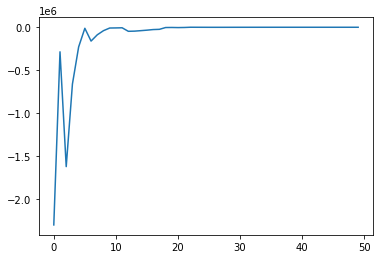

Error in callback <function flush_figures at 0x7f57688479d0> (for post_execute):


KeyboardInterrupt: 

In [41]:
noise_std = starting_noise_std
for i in range(100):
    noise_keys = jax.random.split(noise_keys[0], num=jax.local_device_count())
    train_keys = jax.random.split(noise_keys[0], num=jax.local_device_count())

    policy_params_with_noise,_, noise = add_noise_pmap(policy_params, noise_std, noise_keys)
    #policy_params_with_noise, noise1,noise2 = add_pareto_noise_pmap(policy_params, noise_beta, noise_scale, noise_keys)
    
    rewards_before, obs, acts, states_before = do_rollout_pmap(env_fn, policy.apply, normalizer_params, policy_params_with_noise, train_keys, episode_length, action_repeat, normalize_observations)
    policy_params_trained, rewards_lists = do_apg_pmap(apg_epochs, env_fn, policy.apply, normalizer_params, policy_params_with_noise, train_keys, learning_rate, episode_length, action_repeat, normalize_observations, batch_size, clipping, truncation_length)
    rewards_after, obs, acts, states_after = do_rollout_pmap(env_fn, policy.apply, normalizer_params, policy_params_trained, train_keys, episode_length, action_repeat, normalize_observations)
            
    print(jnp.any(policy_params_trained['params']['Dense_0']['kernel'] - policy_params_with_noise['params']['Dense_0']['kernel']))
    
    top_idx = sorted(range(len(rewards_lists)), key=lambda k: jnp.mean(rewards_lists[k][-5:]), reverse=True)
        
    _, params_def = jax.tree_flatten(policy_params)
    params_flat, _ = jax.tree_flatten(policy_params_trained)
    top_params_flat = [param[top_idx[0]] for param in params_flat]
    top_params = jax.tree_unflatten(params_def, top_params_flat)
    
#     _, norm_def = jax.tree_flatten(normalizer_params)
#     norm_flat, _ = jax.tree_flatten(normalizer_params_all)
#     top_norm_flat = [param[top_idx[0]] for param in norm_flat]
#     top_norms = jax.tree_unflatten(norm_def, top_norm_flat)
    
    noise_beta -= .1
    noise_std  += .005
    
    if jnp.mean(rewards_lists[top_idx[0]][-5:]) > best_reward:
        noise_beta = 2.0
        noise_std =starting_noise_std
        policy_params = top_params
        top_normalizer_params = normalizer_params
        best_reward = jnp.mean(rewards_lists[top_idx[0]][-5:])
        
    normalizer_params = obs_normalizer_update_fn(normalizer_params, obs[top_idx[0],:])
    meta_rewards_list.append(best_reward)
    
    print(f" Iteration {i} --------------------------------")
    
    for j in range(len(top_idx)):
        done_idx = jnp.where(states_before.done[top_idx[j], :], size=1)[0].item()
        if done_idx == 0:
            done_idx = rewards_before.shape[-1]
        rewards_sum_before = jnp.sum(rewards_before[top_idx[j],:done_idx])

        done_idx = jnp.where(states_after.done[top_idx[j], :], size=1)[0].item()
        if done_idx == 0:
            done_idx = rewards_after.shape[-1]
        rewards_sum_after = jnp.sum(rewards_after[top_idx[j],:done_idx])
        
        print(f"{j} : reward: {rewards_sum_before} -> {jnp.mean(rewards_lists[top_idx[j]][-5:])}  |  {rewards_sum_after}")
        
        
    if i %10 == 0: 
        plt.plot(rewards_lists[top_idx[0]])
        plt.figure()
    
    #print(f"{i} : best reward: {rewards_sum_before} -> {rewards_lists[top_idx[0]][-1]}  |  {rewards_sum_after}")

    print("Best reward so far: ", best_reward)
    print('--------------------------------------')

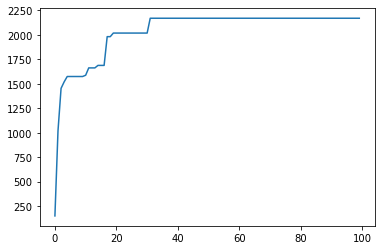

In [33]:
plt.plot(meta_rewards_list)

In [34]:
import brax.jumpy as jp
@jax.jit
def do_rnn_rollout(policy_params, normalizer_params, key):
    init_state = env.reset(key)
    h0 = jp.zeros_like(init_state.obs)

    def do_one_rnn_step(carry, step_idx):
        state, h, policy_params, normalizer_params  = carry

        normed_obs = obs_normalizer_apply_fn(normalizer_params, state.obs)
        h1 , actions = policy.apply(policy_params, h, normed_obs)
        #actions = jp.ones_like(actions)*0.0
        nstate = env.step(state, actions)    
        #h1 = jax.lax.cond(nstate.done, lambda x: jnp.zeros_like(h1), lambda x: h1, None)
        return (jax.lax.stop_gradient(nstate), h1, policy_params, normalizer_params), (nstate.reward,state.obs, actions, nstate)


    _, (rewards, obs, acts, states) = jp.scan(
        do_one_rnn_step, (init_state, h0, policy_params, normalizer_params),
        (jnp.array(range(episode_length // action_repeat))),
        length=episode_length // action_repeat)

    return rewards, obs, acts, states

2214.2153
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

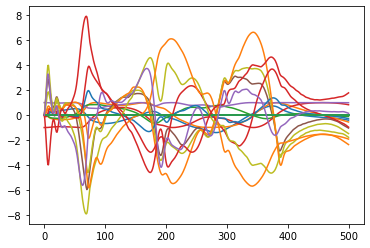

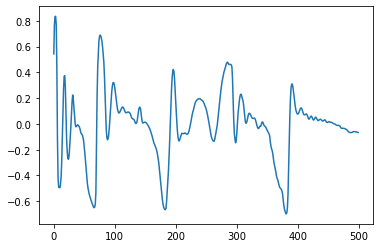

In [35]:
key, reset_key = jax.random.split(key)
(rewards, obs, acts, states) = do_rnn_rollout(policy_params, top_normalizer_params, reset_key)

done_idx = jnp.where(states.done, size=1)[0].item()
if done_idx == 0:
    done_idx = states.done.shape[0]
rewards_sum = jnp.sum(rewards[:done_idx])

plt.plot(obs);
plt.figure()
plt.plot(acts);
print(rewards_sum)
print(states.done)

In [36]:
qp_flat, qp_def = jax.tree_flatten(states.qp)

qp_list = []

for i in range(qp_flat[0].shape[0]):
    qpc=[]
    for thing in qp_flat:
        qpc.append(thing[i,:])
    qp_list.append(jax.tree_unflatten(qp_def, qpc))
    

visualize(env.sys, qp_list, height=800)

In [ ]:
(obs**2).shape